# Подготовка библиотек и данных



1) Для каких рядов не будет работать SARIMA:
Модель SARIMA (сезонная ARIMA) предназначена для работы с временными рядами, у которых есть явные сезонные паттерны. Однако она не будет эффективна для:

Непериодических рядов: Если временной ряд не имеет сезонности (например, случайные колебания без видимого шаблона), SARIMA может оказаться излишне сложной и не даст хороших результатов.
Сильно нестационарных рядов: Если ряд имеет тренд, который не периодически колеблется или не может быть устранён при помощи интерграции, SARIMA может не подойти.
Рядов с малым количеством наблюдений: Если имеется недостаточно данных для выявления сезонных паттернов, модель также не будет эффективной.
Ряды с отсутствующими или нерегулярными данными: Если в данных есть много пробелов, это может привести к проблемам с оценкой сезонных компонентов.

2) Проблемы с исходными данными, если не учитывать пропуски и дубликаты:
Даже если данные кажутся корректными, игнорирование пропусков и дубликатов может привести к нескольким проблемам:

Искажение результатов: Пропуски и дубликаты могут привести к неправильным оценкам параметров модели, что повлияет на точность прогнозов.
Снижение качества модели: Если пропуски не представлены в ходе анализа, это может сильнее исказить данные и привести к неверным выводам.
Ошибки во временных метках: Если дубликаты возникают в данных по временным меткам, это может создать ложные тренды или сезонности.
Проблемы с интерпретацией результатов: Неправильные данные могут привести к неадекватной интерпретации модели и её результатов, что затруднит принятие решений на основе этой информации.

In [1]:
# ip3 install pandas numpy matplotlib statsmodels - если не установлены
#импорт необходимых библиотек
import warnings
import itertools
from calendar import Month

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [2]:
#Загрузка данных
# для локального файла time_series = pd.read_csv('airline_passengers.csv')
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
time_series = pd.read_csv(url)

In [3]:
#просмотр набора начало(голова)
print(time_series.head())

     Month  Passengers
0  1949-01         112
1  1949-02         118
2  1949-03         132
3  1949-04         129
4  1949-05         121


In [4]:
#просомтр набора окончание (хвост)
print(time_series.tail())

       Month  Passengers
139  1960-08         606
140  1960-09         508
141  1960-10         461
142  1960-11         390
143  1960-12         432


# Обработка данных

In [5]:
#проверка пропущенных значений
print(time_series.isnull().sum())

Month         0
Passengers    0
dtype: int64


In [6]:
#В случае обнаружения пропуском их можно заполнить например средними значениями или медианой
# time_series = time_series.fillna(time_series.median())
# Для замены только в конкретном столбце:
#time_series['Столбец 1'] = time_series['Столбец 1'].fillna(time_series['Столбец 1'].median())

In [7]:
time_series.dtypes

Month         object
Passengers     int64
dtype: object

In [8]:
#Проверка и преобразование типов данных
#df.column_name.dtype - для конкретного
#df.dtypes - для всех столбцов
#df.dtypes [df.dtypes=='int64'] - поиск конкретного типа

#преобразование данных в даты
time_series['Month'] = pd.to_datetime(time_series['Month'])

In [9]:
# Просмотр графика с линией тренда
import numpy as np
import matplotlib.pyplot as plt

def plot_passengers_with_trend(time_series_inp):
    # Сбросить индекс и построить график разброса
    time_series = time_series_inp.copy()
    time_series.reset_index(inplace=True)
    plt.figure(figsize=(10, 6))
    plt.scatter(time_series['Month'], time_series['Passengers'], label='Passengers', color='blue')

    # Расчет коэффициентов для линейной регрессии
    z = np.polyfit(time_series['Month'].astype(int), time_series['Passengers'], 1)
    p = np.poly1d(z)

    # Добавить линию тренда
    plt.plot(time_series['Month'], p(time_series['Month'].astype(int)), color='red', label='Trend Line')

    # Настройка графика
    plt.title('Number of Passengers Over Time with Trend Line')
    plt.xlabel('Month')
    plt.ylabel('Number of Passengers')
    plt.legend()
    
    # Вернуть индекс назад
    
    plt.show()

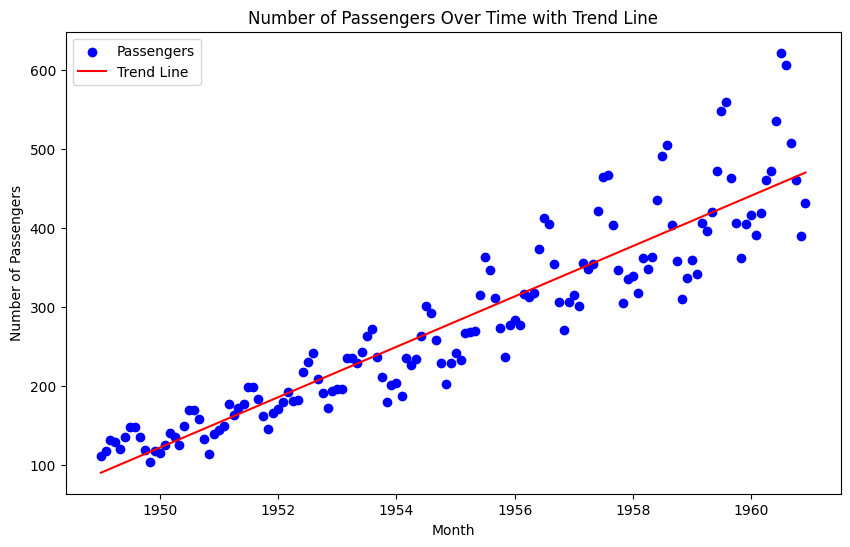

In [10]:
plot_passengers_with_trend(time_series)

In [11]:
#Изменение масштаба данных (нужно в случае если размах слишком велик
#print(time_series.columns)
#time_series.plot.scatter(x='Month', y='Passengers')

In [12]:
#Указание поля Month (DataTime) в качестве индекса. Удобно для работы с временными рядами.
#при установке индекса он пропадет из столбцов и станет индексом
time_series.set_index('Month', inplace=True)

#Изменение масштаба данных (нужно в случае если размах слишком велик
# Пример стандартизации данных 
``` 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
time_series[['Passengers']] = scaler.fit_transform(time_series[['Passengers']])
```


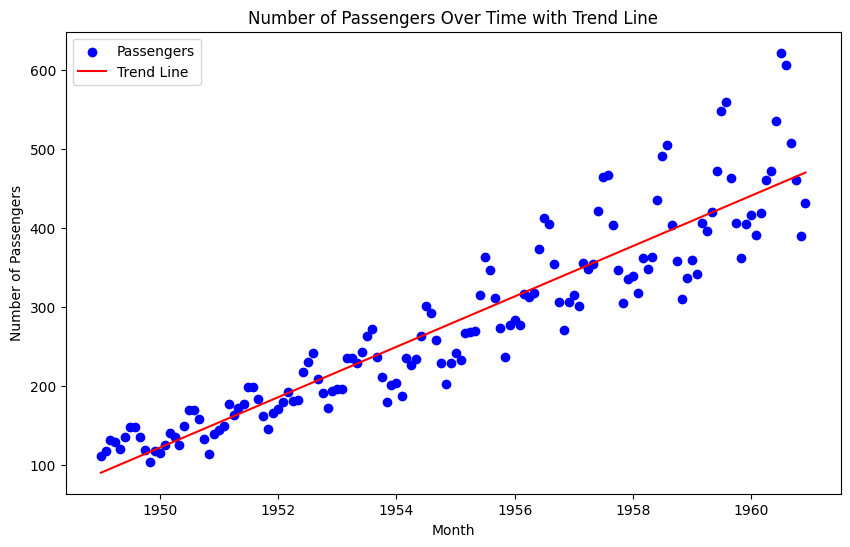

In [13]:
#Проверочный модуль.
plot_passengers_with_trend(time_series)


In [14]:
time_series.dtypes

Passengers    int64
dtype: object

# Визуализация данных

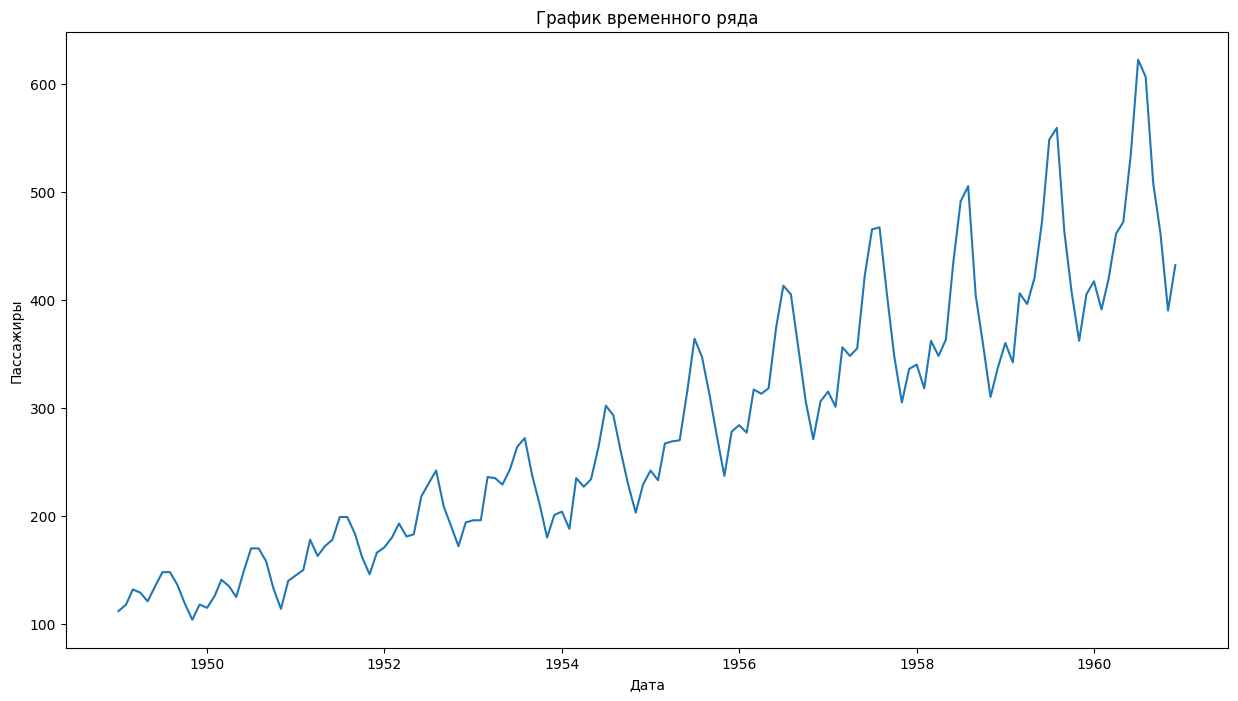

In [15]:
# Построение графика
plt.figure(figsize=(15,8))
plt.plot(time_series['Passengers'])
plt.title('График временного ряда')
plt.xlabel('Дата')
plt.ylabel('Пассажиры')
plt.show()

In [16]:
#Оценка стационарности ряда тесто Дики-фуллера
from statsmodels.tsa.stattools import adfuller

def dik_full_test(time_series_ex):
    time_series = time_series_ex.copy()
    print('Результат теста:')
    df_result = adfuller(time_series['Passengers'])
    df_labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    for result_value, label in zip(df_result, df_labels):
        print(label + ' : ' + str(result_value))
    
    if df_result[1] <= 0.05:
        print("Сильные доказательства против нулевой гипотезы, ряд является стационарным.")
    else:
        print("Слабые доказательства против нулевой гипотезы, ряд не является стационарным.")
# в случае не стационарности необходимо найти парамтеры для модели ARIMA для приведения к стационарности

### Способы приведения к стационарности
Дифференцирование: один из самых распространенных методов, именно с помощью дифференцирования ARIMA приводит ряд к стационарности. Этот процесс основывается на вычислении разницы между последовательными наблюдениями во временном ряду. 

Сезонное дифференцирование: вариация обычного дифференцирования, которая применяется для данных с сезонной компонентой

Логарифмирование: создание логарифма данных может помочь снизить вариативность ряда и сделать его более стационарным. 

In [17]:
dik_full_test(time_series)

Результат теста:
ADF Test Statistic : 0.8153688792060482
p-value : 0.991880243437641
#Lags Used : 13
Number of Observations Used : 130
Слабые доказательства против нулевой гипотезы, ряд не является стационарным.


# Модель ARIMA
 ARIMA (AutoRegressive Integrated Moving Average), Авторегрессионное интегрированное скользящее среднее — это статистическая модель, которая используется для анализа и прогнозирования данных динамических рядов. 

1. Авторегрессионная (AR) часть относится к использованию зависимости между текущим наблюдением и определенным количеством предыдущих наблюдений. Например, чтобы предсказать погоду на завтра, мы смотрим погоду в предыдущие дни. 

2. Интегрированная (I) часть обозначает, что данные временного ряда преобразуются с целью сделать ряд стационарным. Под стационарностью подразумевается такое свойство временного ряда, при котором его статистические характеристики не меняются во времени. Например, среднее и дисперсия остаются постоянными со временем. Обычно это достигается путем применения операции разности к ряду один или несколько раз. 

3. Скользящее среднее (MA) относится к моделированию ошибки между реальным наблюдением и прогнозируемым значением, используя комбинацию значений ошибок предыдущих шагов. 

Модель ARIMA обычно обозначается как ARIMA (p, d, q), где p, d и q — параметры модели: 

p — порядок авторегрессии, который описывает количество предыдущих наблюдений, принимаемых во внимание в модели. 

d — порядок интегрирования, который указывает, сколько раз нужно взять разность временного ряда для достижения стационарности. 

q — порядок скользящего среднего, который связан с количеством предыдущих ошибок, используемых в модели.

Выбор подходящих значений (p, d, q) в модели ARIMA — это искусство и наука, требующая обращения с автокорреляционными и частными автокорреляционными графиками, а также применения информационных критериев. 

# Сезонная модель SARIMA
Сезонная модель ARIMA или SARIMA (Seasonal Autoregressive Integrated Moving Average) — это расширение модели ARIMA, добавляющее в нее понятие сезонности. В ряде ситуаций динамические ряды отражают явные сезонные колебания. Позволяет уловить сезонные колебания.

Сезонная модель ARIMA обычно обозначается как SARIMA (p, d, q) (P, D, Q) m, где p, d, q — это несезонные параметры, а P, D, Q — сезонные:

p, d, q работают также, как и в ARIMA.

P — порядок сезонной авторегрессии, и он основан на количестве предыдущих сезонов, которые влияют на текущий сезон.

D — порядок сезонной интеграции, то есть сколько раз нужно продифференцировать данные, чтобы убрать сезонные тренды.

Q — порядок сезонного скользящего среднего, то есть как много предыдущих сезонных ошибок прогноза используется в модели.

m — это длина сезонного периода. Например, если данные имеют годовую сезонность и данные собираются ежемесячно, то m будет равно 12. 

# Определение параметров модели
Для настройки используется поиск по сетке(grid search)
цель — найти баланс между временем, затраченным на «поиск по сетке», и качеством исходной модели, то есть найти такие значения параметров, при которых качество будет наибольшим, а затраты времени минимальными.

In [18]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#игнорируем предупреждения о возможных проблемах или не оптимальности
warnings.filterwarnings("ignore")

#Создание диапазона параметров для настройки модели
def search_optimal_sarima(time_series, seasonal_cycle):
    order_vals = diff_vals = ma_vals = range(0, 2)
    pdq_combinations = list(itertools.product(order_vals, diff_vals, ma_vals))
    seasonal_combinations = [(combo[0], combo[1], combo[2], seasonal_cycle) for combo in pdq_combinations]
       
    smallest_aic = float("inf")
    optimal_order_param = optimal_seasonal_param = None

    for order_param in pdq_combinations:
        for seasonal_param in seasonal_combinations:
            try:
                sarima_model = sm.tsa.statespace.SARIMAX(time_series,
                                                         order=order_param,
                                                         seasonal_order=seasonal_param,
                                                         enforce_stationarity=False,
                                                         enforce_invertibility=False)

                model_results = sarima_model.fit()
                if model_results.aic < smallest_aic:
                    smallest_aic = model_results.aic
                    optimal_order_param = order_param
                    optimal_seasonal_param = seasonal_param
            except:
                continue

    print('ARIMA{}x{} - AIC:{}'.format(optimal_order_param, optimal_seasonal_param, smallest_aic))

seasonal_cycle_length = 12
search_optimal_sarima(time_series, seasonal_cycle_length)


ARIMA(0, 1, 1)x(1, 1, 1, 12) - AIC:920.3192974989254


In [19]:
# ARIMA(0, 1, 1)x(1, 1, 1, 12) - AIC:920.3192974989254 - пример рассчитанного значения для настройки нашей модели.

In [20]:
# Построение и оценка модели SARIMAX
#определяем модель SARIMAX с найденными ранее параметрами
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(time_series, order=(0, 1, 1), seasonal_order=(1, 1, 1, 12))
#Обучаем модель
results = model.fit()
#вывод сводки по модели для оценки качества подбора информации
print(results.summary())



                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -506.164
Date:                            Sat, 21 Sep 2024   AIC                           1020.327
Time:                                    20:19:48   BIC                           1031.828
Sample:                                01-01-1949   HQIC                          1025.001
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3441      0.073     -4.701      0.000      -0.487      -0.201
ar.S.L12      -0.9382      0.206   

Основные пункты, на которые следуют обратить внимание:

1. Коэффициенты: они должны быть статистически значимыми. Проверьте p-значения коэффициентов (P>|z|); они должны быть меньше 0.05. 

2. Информационный критерий (AIC): меньшее значение AIC указывает на лучшую подгонку модели.

3. Ljung-Box (L1) (Q): это p-значение для Ljung-Box Q-статистики. Если значение больше 0.05, остатки случайны, что хорошо.

4. Jarque-Bera (JB): это тест на нормальность остатков. Если Prob(JB) больше 0.05, остатки нормальны, что хорошо. 

5. Heteroskedasticity (H): это тест на гетероскедастичность остатков. Если Prob(H) (two-sided) больше 0.05, остатки гетероскедастичны, что хорошо. Гетероскедастичность — это ситуация, когда разброс ошибок ваших прогнозов меняется в зависимости от того, в какой точке вы находитесь. Более простыми словами, это когда у вас имеется неоднородность в ваши


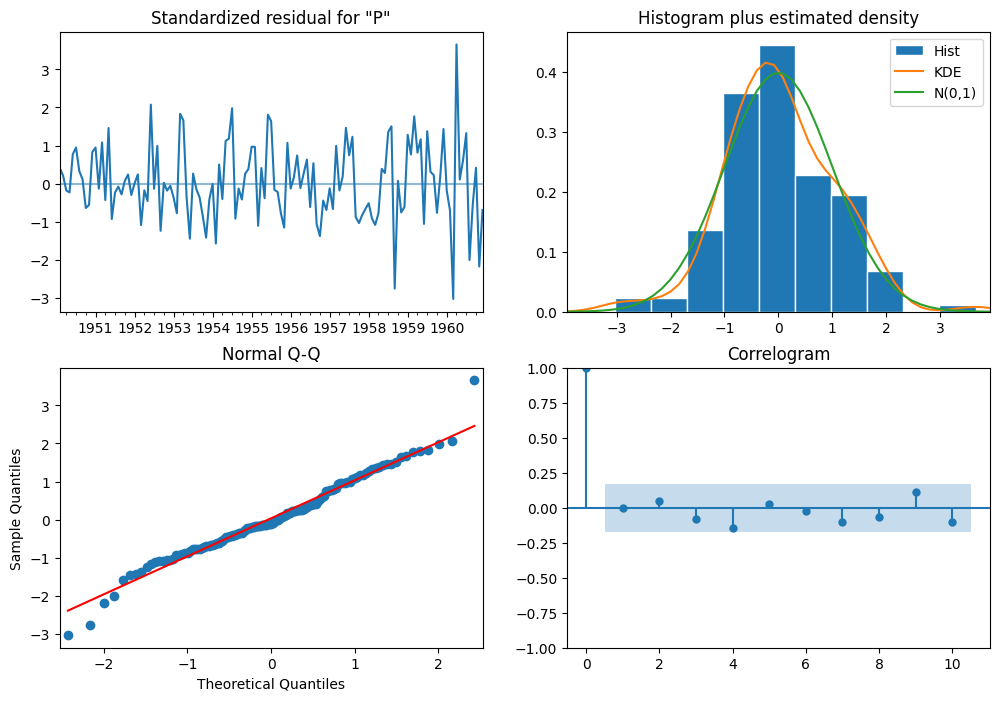

In [21]:
#Визуализация результатов
results.plot_diagnostics(figsize=(12, 8))
plt.show()

# Расшифровка визуализации
Кривая остатков — это график остатков модели по времени. Если модель хороша, остатки будут случайными, и график будет выглядеть как белый шум. 

График нормального квантиля (Q-Q plot) — это график, который сравнивает распределение остатков с идеальным нормальным распределением. Если точки следуют диагональной линии, это означает, что остатки нормально распределены.

График коррелограммы — это график автокорреляции остатков. Если модель хороша, остатки не будут коррелировать друг с другом. Отсутствие голубых полосок за пределами голубого диапазона шума указывает на это. 

Гистограмма остатков — это гистограмма распределения остатков. Если модель хороша, остатки должны быть нормально распределены, и эта гистограмма будет напоминать форму колокола. 

### Модель обучена

# Cтатистический прогноз
#get_prediction возвращает объект прогнозирования, из которого мы можем извлечь прогнозные значения при помощи predicted_mean:

In [22]:
st_pred = results.get_prediction(start=pd.to_datetime('1955-12-01'), dynamic=False) 
forecast_values = st_pred.predicted_mean

In [23]:
#будем использовать среднеквадратичную ошибку (MSE) как нашу метрику оценки точности прогноза:
actual_values = time_series['1955-12-01':]['Passengers']
forecast_mse = ((forecast_values - actual_values) ** 2).mean()
print('Среднеквадратичная ошибка прогноза составляет {}'.format(round(forecast_mse, 2)))
#Чем ниже значение MSE, тем точнее модель.

Среднеквадратичная ошибка прогноза составляет 170.37


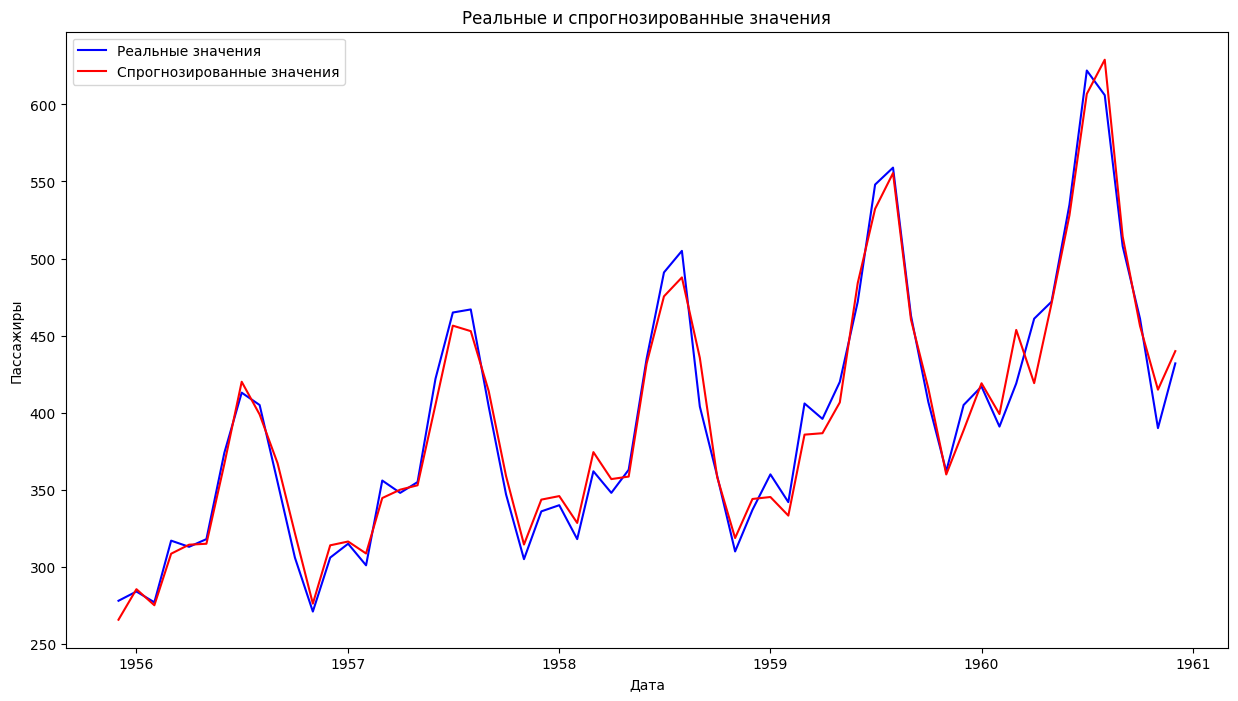

In [24]:
#визуализируем результаты
plt.figure(figsize=(15,8))

plt.plot(actual_values.index, actual_values, label='Реальные значения', color='blue')

plt.plot(forecast_values.index, forecast_values, label='Спрогнозированные значения', color='red')

plt.title('Реальные и cпрогнозированные значения')
plt.xlabel('Дата')
plt.ylabel('Пассажиры')
plt.legend()

plt.show()

# Динамический прогноз
В статическом прогнозе модель использует весь известный набор данных для прогнозирования каждого следующего значения. Динамический прогноз начинает использовать самые свежие прогнозные значения для предсказания будущих значений, после определенной пользователем даты старта.

In [25]:
#меняем dynamic на True
dyn_pred = results.get_prediction(start=pd.to_datetime('1955-12-01'), dynamic=True) 
dynamic_forecast_values = dyn_pred.predicted_mean
#Рассчитываем среднеквадратичную ошибку для динамического прогноза
mse_dynamic_forecast = ((dynamic_forecast_values - actual_values) ** 2).mean()
print('Среднеквадратичная ошибка динамического прогноза составляет {}'.format(round(mse_dynamic_forecast, 2)))

Среднеквадратичная ошибка динамического прогноза составляет 669.33


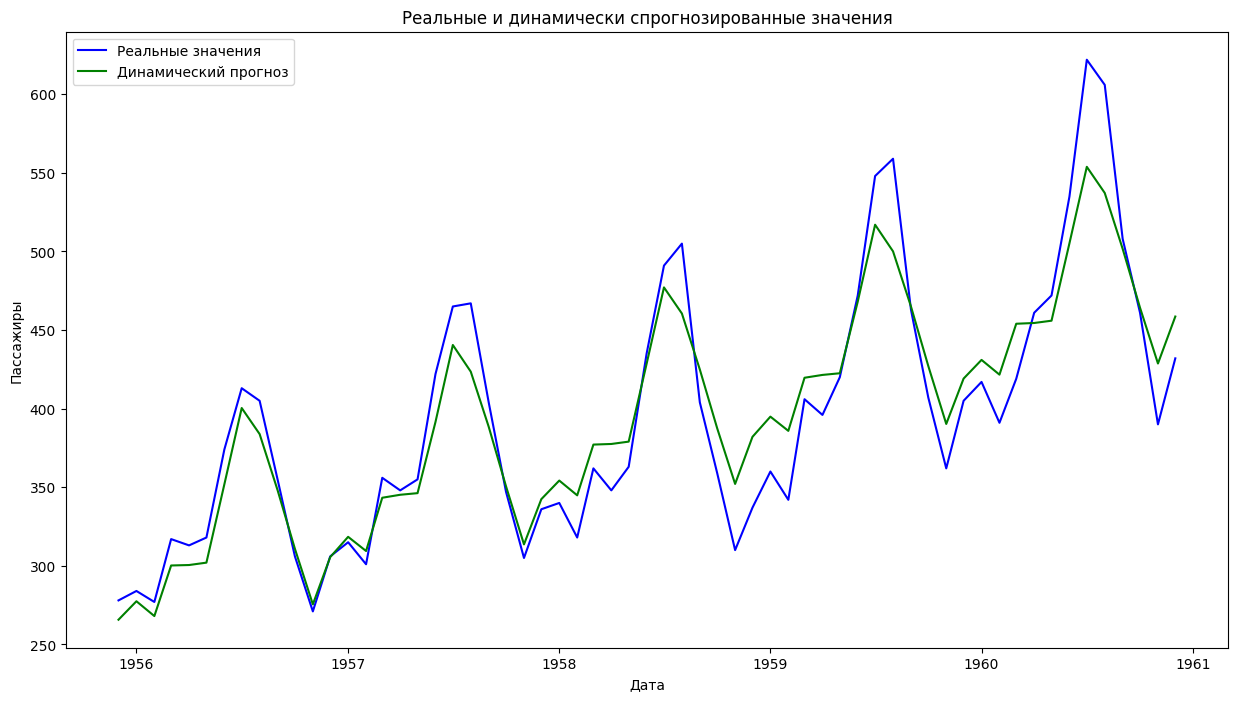

In [26]:
#Визуализируем график реальных и прогнозируемых значений
plt.figure(figsize=(15,8))

plt.plot(actual_values.index, actual_values, label='Реальные значения', color='blue')

plt.plot(dynamic_forecast_values.index, dynamic_forecast_values, label='Динамический прогноз', color='green')

plt.title('Реальные и динамически спрогнозированные значения')
plt.xlabel('Дата')
plt.ylabel('Пассажиры')
plt.legend()

plt.show()

# Создание и визуализация прогноза БУДУЩЕГО

#Мы используем обученную модель (results) для получения прогноза на следующие 12 периодов времени. Поскольку наши данные содержали информацию до декабря 1960 года, здесь мы получим предсказание о количестве пассажиров каждый месяц на 1961 год. 
- Краткосрочные прогнозы: Обычно это 1-3 периода (дня, недели, месяца). Такие прогнозы, как правило, обладают высокой точностью. 
- Среднесрочные прогнозы: Обычно от 3 до 12 месяцев. Здесь точность может начать снижаться, но хорошие модели всё еще могут давать приемлемые результаты. 📈
- Долгосрочные прогнозы: 1-2 года и более. Точность сильно снижается из-за неопределенности изменений в данных, внешних факторов и влияния трендов. Однако, иногда можно использовать сценарный анализ для планирования.


In [27]:
 pred_future = results.get_forecast(steps=64)

#Выведем средние прогнозируемые значения и доверительные интервалы:
print(f'Средние прогнозируемые значения:\n\n{pred_future.predicted_mean}')
print(f'\nДоверительные интервалы:\n\n{pred_future.conf_int()}')

Средние прогнозируемые значения:

1961-01-01    450.455294
1961-02-01    425.641165
1961-03-01    460.178518
1961-04-01    499.276277
1961-05-01    511.217960
                 ...    
1965-12-01    611.541649
1966-01-01    626.682729
1966-02-01    600.877341
1966-03-01    629.950180
1966-04-01    671.473896
Freq: MS, Name: predicted_mean, Length: 64, dtype: float64

Доверительные интервалы:

            lower Passengers  upper Passengers
1961-01-01        428.039474        472.871114
1961-02-01        398.835266        452.447065
1961-03-01        429.606578        490.750457
1961-04-01        465.353855        533.198700
1961-05-01        474.247458        548.188463
...                      ...               ...
1965-12-01        242.956655        980.126642
1966-01-01        246.885619       1006.479839
1966-02-01        211.800275        989.954407
1966-03-01        231.809398       1028.090961
1966-04-01        264.471193       1078.476599

[64 rows x 2 columns]


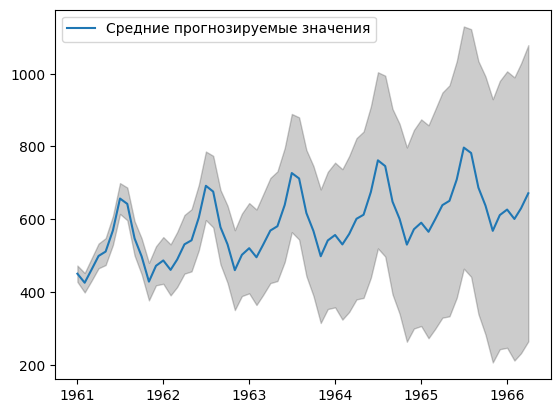

In [28]:
#Визуализация прогноза
fig = plt.figure()
plt.plot(pred_future.predicted_mean, label='Средние прогнозируемые значения')
plt.fill_between(pred_future.conf_int().index,
                 pred_future.conf_int().iloc[:, 0],
                 pred_future.conf_int().iloc[:, 1], color='k', alpha=.2)
plt.legend()  
plt.show()

Средние прогнозные значения показывают ожидаемое количество, а заполненная область вокруг прогноза представляет собой доверительный интервал.